## 前言
**很多文档不仅仅包含文字，还包含图片，表格等其他类型的信息。然而在大多数 RAG 应用中，图像信息都会被略过，这大大降低了能源，教育等图片知识密集型的行业客户的体验。随着多模态 LLM（如 Claude3）的出现，RAG框架可以充分利用图像、表格等信息，生成更加准确和生动的描述。**

[Langchain](https://github.com/langchain-ai/langchain/blob/master/cookbook/multi_modal_RAG_chroma.ipynb)给出了下列三种多模态RAG路径：

方式一：
* 使用多模态Embedding模型（例如 CLIP、 Amazon Titan Multimodal Embedding）来对图像和文本做Embedding
* 使用相似性搜索检索图像和文本
* 将检索到的图像和文本块传递给多模态LLM以生成回答

方式二：
* 使用多模态 LLM（例如 Claude 3）从图像生成summary，对text summary和image summary进行Embedding
* 使用相似性搜索检索summary
* 将summary传递给LLM进行答案生成

方式三：
* 使用多模态 LLM（例如 Claude 3）从图像生成summary，对text summary和image summary做Embedding，并在image summary metadata添加对原图的引用
* 使用相似性搜索检索summary
* 将summary传递给LLM进行答案生成 (检索到image summary后可以根据引用呈现图片)

**本实验以光伏逆变器用户手册为例，参考第三种方式构建多模态RAG，首先使用Claude3对PDF图片和文字进行总结，然后使用Bedrock Titan Embedding模型对文字总结进行Embedding，构建过程中对每个图片摘要添加对原图的引用，再将向量化的信息存入向量数据库Chroma。通过这种方式，用户可获得图文并茂的问答体验。**

## 0. 安装依赖

In [ ]:
# lock to 0.10.19 due to a persistent bug in more recent versions
! pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch 

In [ ]:
! pip install -U langchain chromadb langchain-experimental # (newest versions required for multi-modal)

## 1. PDF to Image

In [9]:
import pypdfium2 as pdfium
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

In [10]:
def convert_pdf_to_images(file_path, scale=300/72):
    
    pdf_file = pdfium.PdfDocument(file_path)  
    page_indices = [i for i in range(len(pdf_file))]
    
    renderer = pdf_file.render(
        pdfium.PdfBitmap.to_pil,
        page_indices = page_indices, 
        scale = scale,
    )
    
    list_final_images = [] 
    
    for i, image in zip(page_indices, renderer):
        
        image_byte_array = BytesIO()
        image.save(image_byte_array, format='jpeg', optimize=True)
        image_byte_array = image_byte_array.getvalue()
        list_final_images.append(dict({i:image_byte_array}))
    
    return list_final_images

In [21]:
path = "/home/ec2-user/SageMaker/energy/" ##请替换为您的实验目录

In [ ]:
filename = 'x1-mini-g4-user-manual-en.pdf' ##请替换为您的实验文件

In [11]:

convert_pdf_to_images = convert_pdf_to_images(path+filename)

In [12]:
def save_images(list_dict_final_images):
    
    all_images = [list(data.values())[0] for data in list_dict_final_images]

    for index, image_bytes in enumerate(all_images):

        image = Image.open(BytesIO(image_bytes))
        image.save(f'{path}{index}.jpg')

In [13]:
save_images(convert_pdf_to_images)

## 2. Extract Text

In [22]:
from langchain_community.document_loaders import PDFMinerPDFasHTMLLoader

loader = PDFMinerPDFasHTMLLoader(path+filename)

data = loader.load()[0]   # entire PDF is loaded as a single Document

In [23]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(data.page_content,'html.parser')
content = soup.find_all('div')

In [24]:
import re
cur_fs = None
cur_text = ''
snippets = []   # first collect all snippets that have the same font size
for c in content:
    sp = c.find('span')
    if not sp:
        continue
    st = sp.get('style')
    if not st:
        continue
    fs = re.findall('font-size:(\d+)px',st)
    if not fs:
        continue
    fs = int(fs[0])
    if not cur_fs:
        cur_fs = fs
    if fs == cur_fs:
        cur_text += c.text
    else:
        snippets.append((cur_text,cur_fs))
        cur_fs = fs
        cur_text = c.text
snippets.append((cur_text,cur_fs))
# Note: The above logic is very straightforward. One can also add more strategies such as removing duplicate snippets (as
# headers/footers in a PDF appear on multiple pages so if we find duplicates it's safe to assume that it is redundant info)

In [25]:
from langchain.docstore.document import Document
cur_idx = -1
semantic_snippets = []
# Assumption: headings have higher font size than their respective content
for s in snippets:
    # if current snippet's font size > previous section's heading => it is a new heading
    if not semantic_snippets or s[1] > semantic_snippets[cur_idx].metadata['heading_font']:
        metadata={'heading':s[0], 'content_font': 0, 'heading_font': s[1]}
        metadata.update(data.metadata)
        semantic_snippets.append(Document(page_content='',metadata=metadata))
        cur_idx += 1
        continue

    # if current snippet's font size <= previous section's content => content belongs to the same section (one can also create
    # a tree like structure for sub sections if needed but that may require some more thinking and may be data specific)
    if not semantic_snippets[cur_idx].metadata['content_font'] or s[1] <= semantic_snippets[cur_idx].metadata['content_font']:
        semantic_snippets[cur_idx].page_content += s[0]
        semantic_snippets[cur_idx].metadata['content_font'] = max(s[1], semantic_snippets[cur_idx].metadata['content_font'])
        continue

    # if current snippet's font size > previous section's content but less than previous section's heading than also make a new
    # section (e.g. title of a PDF will have the highest font size but we don't want it to subsume all sections)
    metadata={'heading':s[0], 'content_font': 0, 'heading_font': s[1]}
    metadata.update(data.metadata)
    semantic_snippets.append(Document(page_content='',metadata=metadata))
    cur_idx += 1

In [26]:
print(str(semantic_snippets[0].page_content))

Solax Power Network Technology(Zhejiang) Co., Ltd.
No.288 Shizhu Road, Tonglu Economic Development Zone, Tonglu City, Zhejiang Province, 
China.
Tel: +86 0571-56260011
E-mail: info@solaxpower.com
320101046701
Copyright Declaration
The copyright of this manual belongs to Solax Power Network Technology(Zhejiang) Co., 
Ltd. 
Any corporation or individual should not plagiarize, partially or fully copy (including 
software, etc.), and no replication or distribution of it in any form or by any means. All 
rights reserved. SolaX Power Network Technology (Zhejiang) Co., Ltd. reserves the right 
of ﬁnal interpretation.



In [27]:
# Categorize text elements by type
texts = []
for item in semantic_snippets:
    texts.append(str(item.page_content))

## 3. Text and Image Summary

In [28]:
# Image summarizer

import base64
import os

#from langchain.chat_models import ChatOpenAI
from langchain_community.chat_models import BedrockChat
from langchain.schema.messages import HumanMessage

class ImageSummarizer:

    def __init__(self, image_path) -> None:
        self.image_path = image_path
        self.prompt = """
You are an assistant tasked with summarizing images for retrieval.
These summaries will be embedded and used to retrieve the raw image.
Give a concise summary of the image that is well optimized for retrieval.
"""

    def base64_encode_image(self):
        with open(self.image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")

    def summarize(self, prompt = None):
        base64_image_data = self.base64_encode_image()
        chat = BedrockChat(model_id="anthropic.claude-3-sonnet-20240229-v1:0",model_kwargs={"temperature": 0, "max_tokens": 1024})

        # gpt4 vision api doc - https://platform.openai.com/docs/guides/vision
        response = chat.invoke(
            [
                HumanMessage(
                    content=[
                        {
                            "type": "text",
                            "text": prompt if prompt else self.prompt
                        },
                        {
                            "type": "image",
                            "source":  {"type": "base64","media_type": "image/jpeg","data": base64_image_data},
                        },
                    ]
                )
            ]
        )
        return base64_image_data, response.content
     

In [29]:
images_path = path
image_data_list = []
image_summary_list = []

for img_file in sorted(os.listdir(images_path)):
    if img_file.endswith(".jpg"):
        summarizer = ImageSummarizer(os.path.join(images_path, img_file))
        data, summary = summarizer.summarize()
        image_data_list.append(data)
        image_summary_list.append(summary)

In [30]:
image_summary_list

['This image appears to be the cover page or title page of a user manual for the X1 Series solar inverters from Solax Power. The manual covers models ranging from 0.6kW to 3.3kW capacity. The page displays the company\'s logo, product image, title "X1 Series User Manual", power range, company name, address, copyright declaration, and website. The color scheme is predominantly red, orange, and white.',
 'The image shows a "Change History" section that lists the version updates for a document or software. It mentions that changes between versions are cumulative, with the latest version 01 (Jan. 3, 2023) having updated technical data, while version 00 (Sept. 27, 2022) was the initial release.',
 'This image shows the packing list and installation precautions for an outdoor inverter. It lists the included components like the inverter, bracket, expansion tube, earth terminal, AC connector, DC pin contact, RJ45 terminal, and dongle. It also provides icons indicating the appropriate installat

In [35]:
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

prompt_text = """
  You are responsible for concisely summarizing text chunk:

  {element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)
summarize_chain = {"element": lambda x: x} | prompt | BedrockChat(model_id="anthropic.claude-3-sonnet-20240229-v1:0",model_kwargs={"temperature": 0, "max_tokens": 1024}) | StrOutputParser()
     

In [36]:
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

## 4. Embedding and Vector Store

In [37]:
import uuid

#from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings import BedrockEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma

id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=Chroma(collection_name="summaries", embedding_function=BedrockEmbeddings()),
    docstore=InMemoryStore(),
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

doc_ids = [str(uuid.uuid4()) for _ in image_data_list]
summary_images = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(image_summary_list)
]
retriever.vectorstore.add_documents(summary_images)
retriever.docstore.mset(list(zip(doc_ids, image_data_list)))

## 5. Build RAG Chain

In [38]:
from PIL import Image
from IPython.display import HTML, display



def plt_img_base64(img_base64):
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}"/>'

    # with open(f"{uuid.uuid4()}-data.html", "w") as file:
    #     file.write(image_html)
    display(HTML(image_html))

def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content

        if is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image",
                "source":  {"type": "base64","media_type": "image/jpeg","data": image},
            }
            messages.append(image_message)

    # Adding texts to the messages
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    text_message = {
        "type": "text",
        "text": (
            #"You are financial analyst.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to answer the user question and output in Chinese. \n"
            f"Question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

In [39]:
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

model = BedrockChat(model_id="anthropic.claude-3-sonnet-20240229-v1:0",model_kwargs={"temperature": 0, "max_tokens": 1024})

# RAG pipeline
chain = (
    {
        "context": retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(img_prompt_func)
    | model
    | StrOutputParser()
)

## 6. Test

In [40]:
query = "LCD Operation"

In [41]:
docs = retriever.get_relevant_documents(query, k=3)
len(docs)

4

is_image_data 0: True



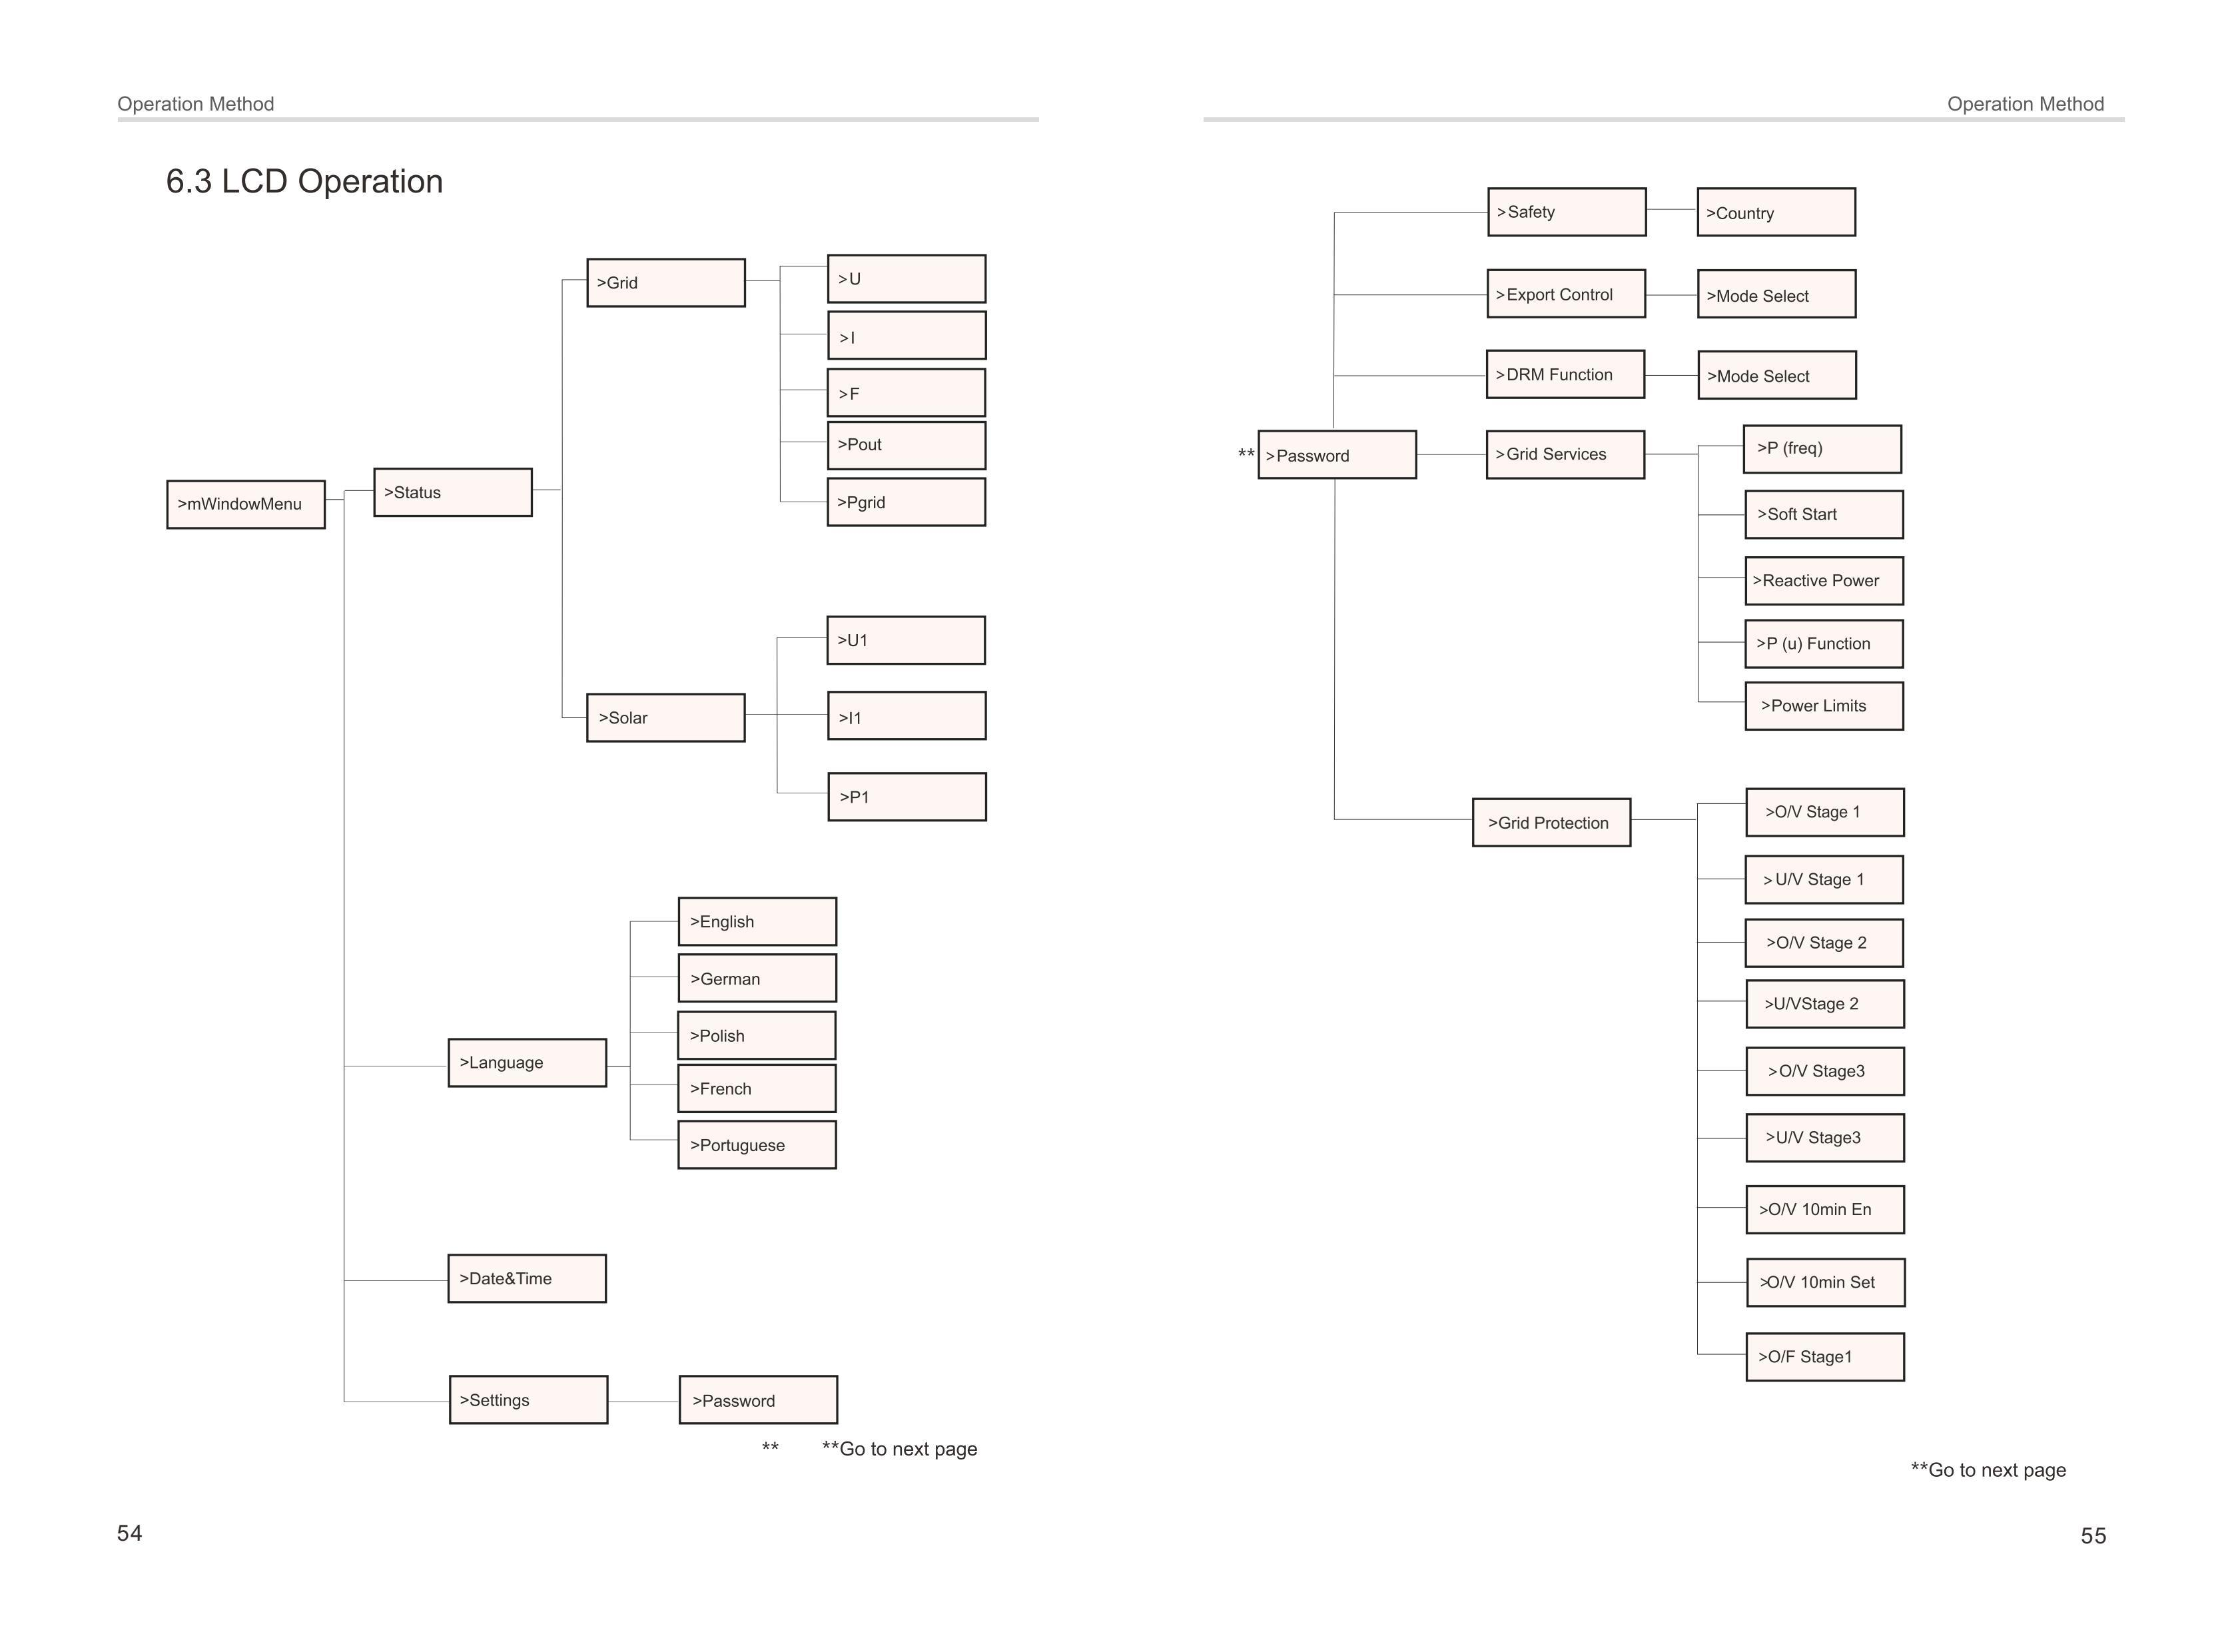

is_image_data 1: True



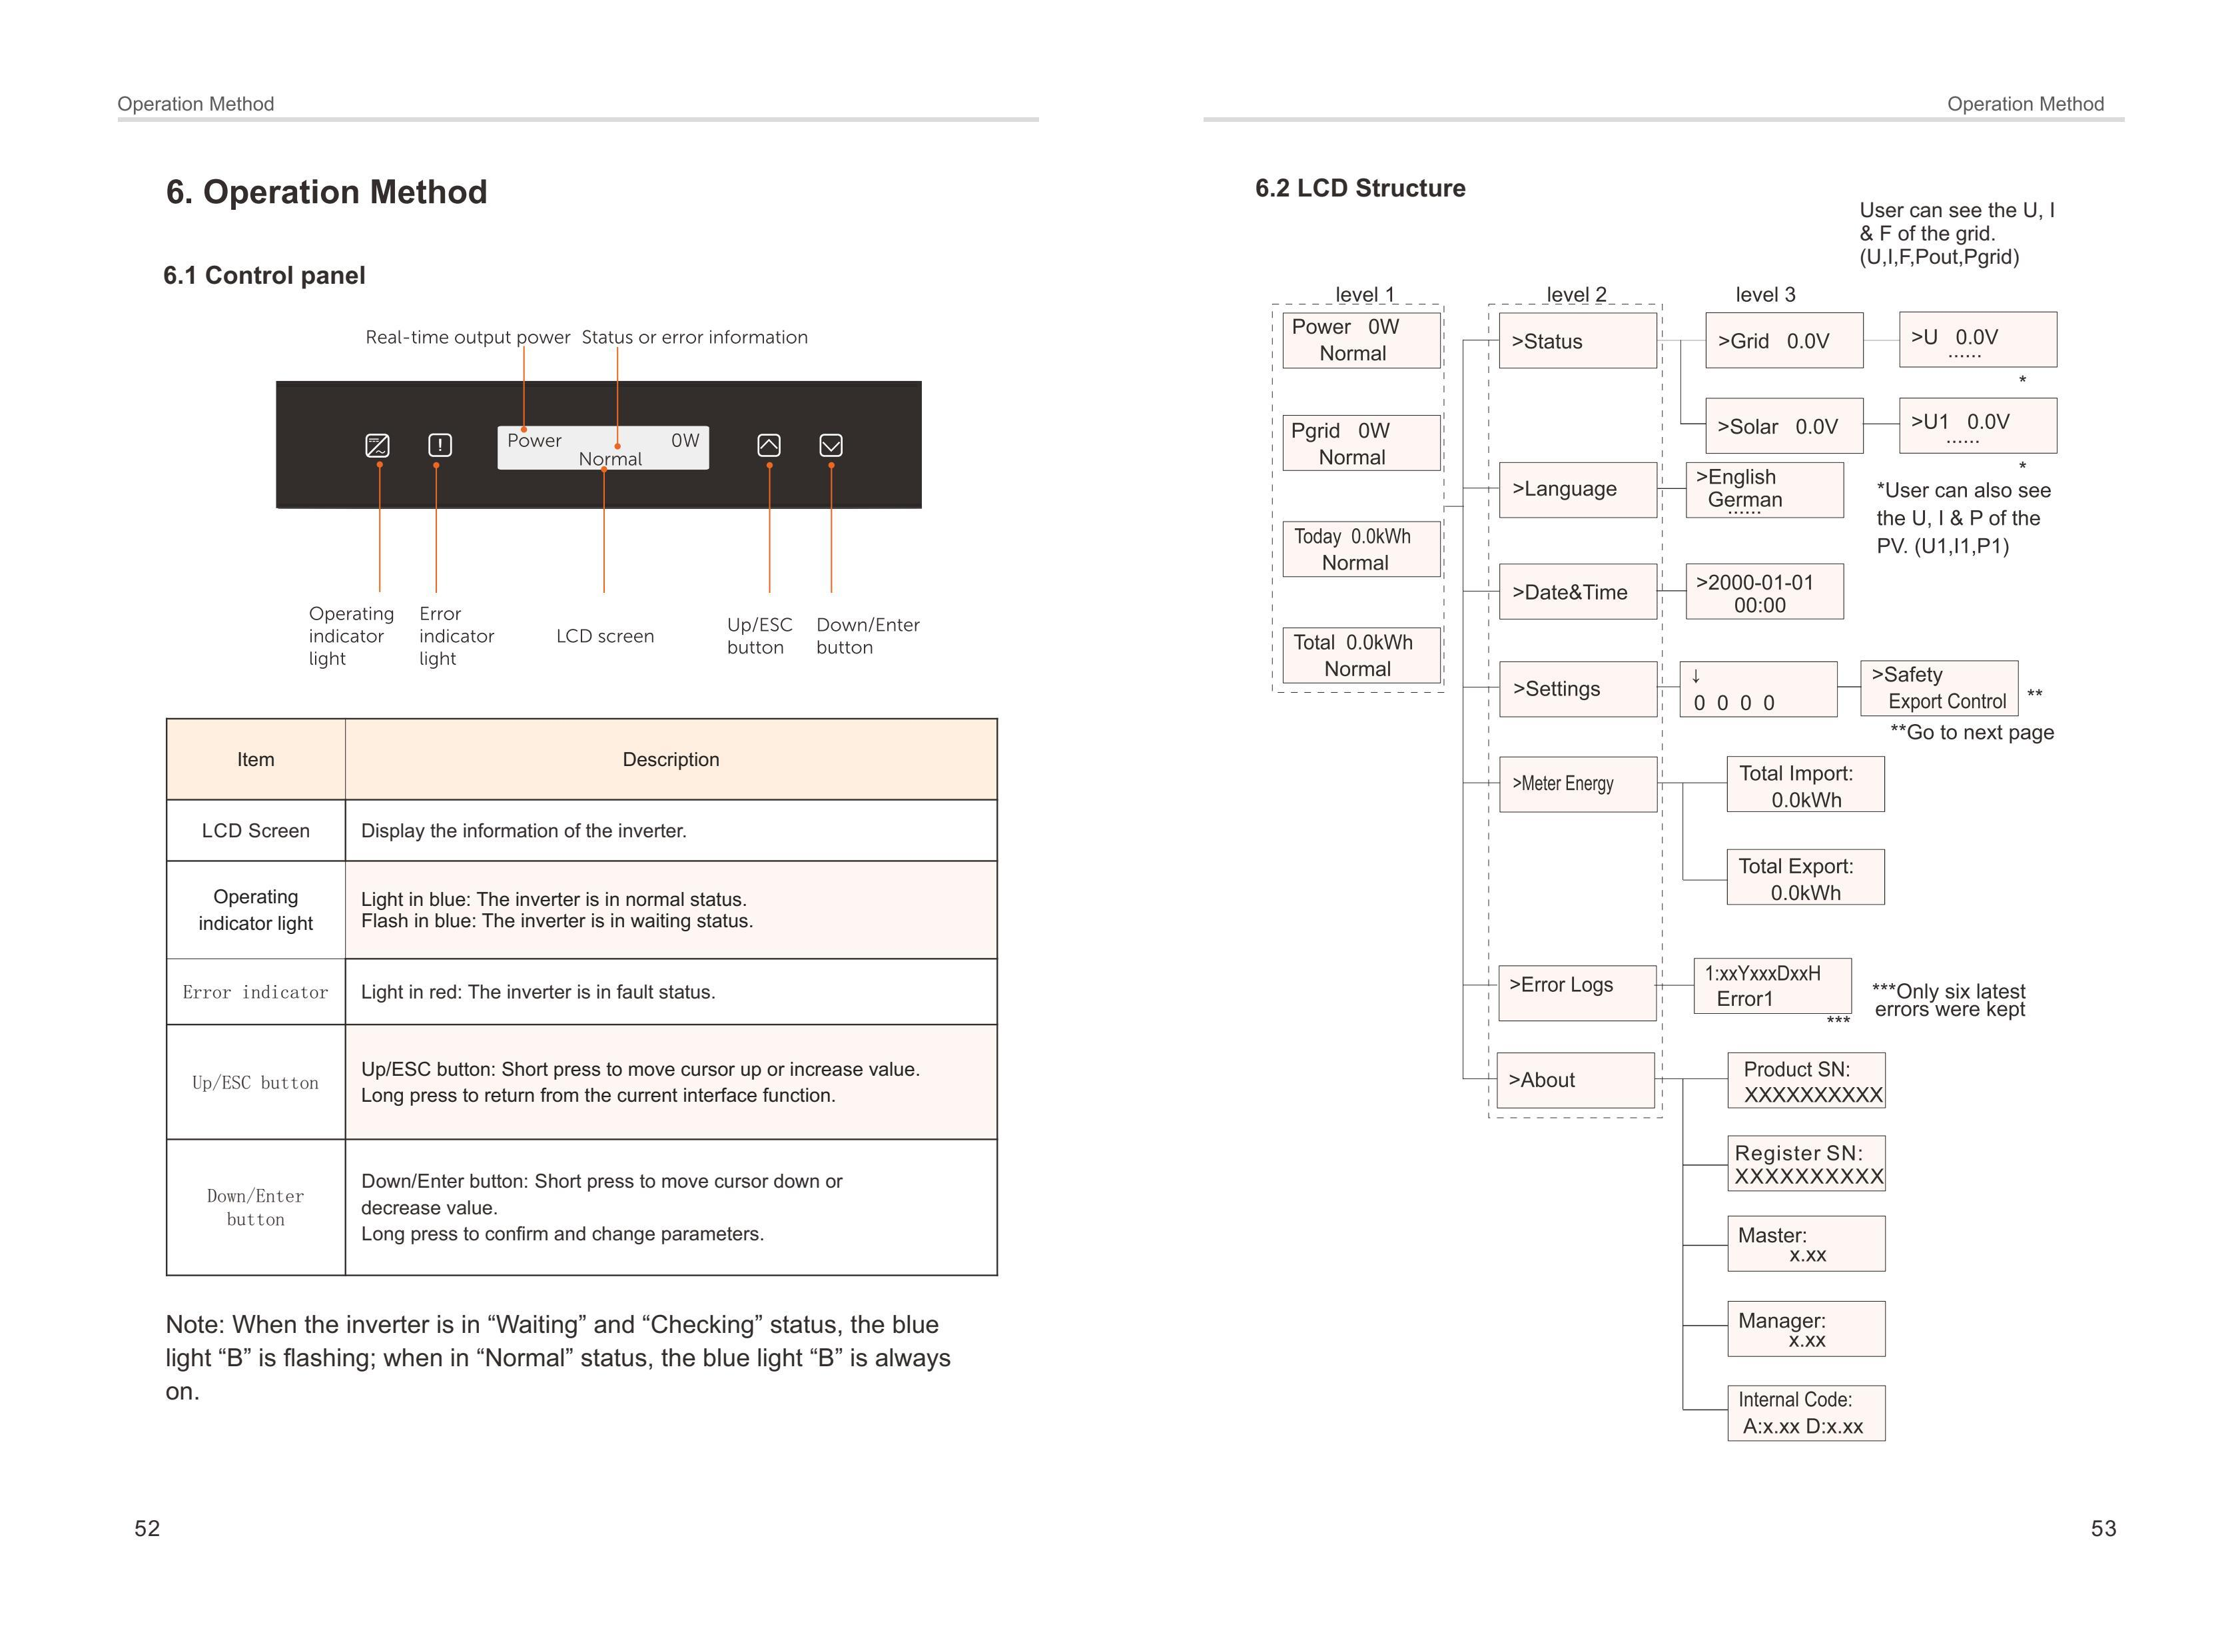

is_image_data 2: False
• Level 1
Power   0W
Normal
Pgrid   0W
Normal
Today  0.0kWh
Normal
Total  0.0kWh
Normal
Status
>Grid
Solar
1) The ﬁrst line displays the parameters(Power,  Pgrid, Today and Total) and
 the values.
1) Grid
Parameter
Meaning
Power
The output power of inverter.
This status shows the current condition of the AC output port of the
inverter, such as voltage, current, output power and grid power.
This status includes 5 parameters: U, I, F, Pout, Pgrid. 
Press “Up“ and “Down” to select and long press “down” to conﬁrm the 
Pgrid
The power export to or import from the grid; (Positive value means the energy feeds 
into grid, negative value means the energy used from the grid).  
selection, long press “Up” to return.
Today
The power generated within the day.
Total
The power generated in total.
2) The second line shows the running status.
    “Normal” means the running status of the inverter.
• Level 2
Long press the “Enter” button to enter the second-level interface. 
User c

In [42]:
for i in range(len(docs)):
    print(f"is_image_data {i}: {is_image_data(docs[i])}")
    if is_image_data(docs[i]):
        plt_img_base64(docs[i])
    else:
        print(docs[i])

In [43]:
chain.invoke(query)

'根据所给的信息,LCD操作界面主要分为三个层级:\n\n第一层级:\n显示功率、电网功率、当日发电量和总发电量等参数值,以及运行状态(正常或异常)。\n\n第二层级:\n长按"Enter"按钮进入,可查看状态、语言、日期时间、设置(需密码)、电表能量(总进口、总出口)、错误日志和关于(产品序列号、机型、注册序列号等信息)等菜单项。\n- 状态菜单包括电网和太阳能两个方面的实时数据。\n- 语言菜单可选择英语、德语等多种语言。\n- 日期时间菜单用于设置系统日期和时间。\n- 设置菜单需要密码,可设置安全标准、电网参数、功率因数等。\n\n第三层级:\n长按"Enter"进入,可查看电网和太阳能的U/I/P等详细参数值。也可在此层级下进入设置菜单修改各项参数。\n\n总的来说,LCD操作界面分多层显示,用户可逐级查看和设置逆变器的运行状态、参数等信息。'